*** 
# Bias Causality template notebook

**+++ Clone the notebook before editing. +++**

Template notebook for estimating the causal effect of a system on bias against some protected characteristic; e.g. how much is a recommender responsible for displaying a disproportionate amount of items of category A, and too few of category B (protected characteristic).

**Inputs:**
* historical data (e.g. individual requests to the system) containing:
  * treatment (e.g. whether the recommender was used to respond to the request)
  * outcomes (e.g. whether the response was category A or category B)
  * other factors that could be "confounding" the observed effect of the treatment to the outcome (e.g. the country the request was sent from)
* a graphical model of the causality structure in the system (aka causal model); this should represent how treatment, outcome and confounding factors relate to each other from a causality point of view (see an example [here](http://www.dagitty.net/dags.html#))


**Outputs:**
* correlation analysis: "are treatment and outcome correlated and if so by how much?", or "is there an observed bias in the system?" 
* causal analysis, i.e. "does the treatment directly cause the outcome, all other factors being equal?", or "does the system directly cause the observed bias?" 


**Requirements:**
* Cluster creation rights (this needs a custom cluster)
* Access to instance profile "mount-recs-ip"
* Python 3.7+
* Python libraries: 
  * numpy>=1.20.2
  * pandas>=1.1.5
  * scikit-learn
  * dowhy https://github.com/microsoft/dowhy

**How to guide:**
1. Clone the notebook;
1. Attach to custom cluster with appropriate instance profile and libraries installed (see "Requirements"); a single-node cluster is recommended as computations are not parallelised (a 'm4.2xlarge' is enough for a 200k rows dataset);
1. Fill the notebook inputs in the "Input" section below:
  * "Causal model (dot or dagitty format)": string representation of causal model; can be either in dot format or copied from dagitty
    * The model can be drawn on http://www.dagitty.net/dags.html: when you are done, simply copy the 'Model code' (right-hand side) into the value or paste to a file and pass the filename (see below);
    * note: there is a 2048 character limit, if the string is longer, please save to s3 and pass the filename (see below)
  * "Causal model (filename)" [alternative to the above]: s3 location of text file containing causal graphical model in either dot format or or copied from dagitty (there is no character limit);
  * "Path to data (S3)": s3 location of the historical dataset, in parquet format; note: the causal inference model will take a long time to run with large (1M+ rows) datasets; 
  * "Outcome name": outcome column name in the historical dataset; note: the outcome column must be categorical, with one of the categories being the protected characteristic;
  * "Treatment name": treatment column name in the historical dataset;
  * "Outcome protected characteristic": name of the protected characteristic in the outcome;
  * "model_params": parameters to pass to the causal model (json format); see dowhy documentation
  * "Random seed"
1. Run notebook;
1. See results under "Analysis" below;

In [ ]:
import pyspark.sql.functions as F
import json
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from dowhy import CausalModel
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import os

In [ ]:
sns.set()

In [ ]:
# This prevents sklearn from printing a lot of warnings (copied from dowhy example notebooks)
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
DATAFRAME_ROW_LIMIT = 10**6

In [ ]:
def load_causal_model(causal_model_filename=None, causal_model=None):
    cm_fname = causal_model_filename
    cm_str = causal_model
    if cm_fname != "":
        cm_str = load_causal_model_from_s3(cm_fname)
        cm = convert_dagitty_to_dot(cm_str)
    elif cm_str != "":
        cm = convert_dagitty_to_dot(cm_str)
    else:
        raise Exception("Please provide a causal model or causal model file location")
    return cm


def load_causal_model_from_s3(s3_loc):
    tmpfile = f"/local_disk0/tmp/{s3_loc.split('/')[-1]}"
    dbutils.fs.cp(s3_loc, tmpfile)
    with open(f'/dbfs/{tmpfile}', 'r') as foo:
        out = foo.read()
    os.remove(f'/dbfs/{tmpfile}')
    return out


def convert_dagitty_to_dot(d):
    d1 = re.sub(r'(^|([\{\}]))\n*', '\\1', d)  # remove newlines where they shouldn't be 
    d1 = re.sub(r'\n', ';', d1)  # replace remaining newlines with ;
    d1 = re.sub(r'\;{2,}', ';', d1)  # clean up multiple ;
    d1 = d1.replace('dag', 'digraph')
    return d1

# Input

In [ ]:
seed = 123
data_filename = "s3://.../bogus-causality-dataset-01/"
causal_model_filename = "s3://.../bogus-causality-model-00.dot"
treatment_name = "used_recommender"
outcome_name = "team"
outcome_pc_name = "blues"
model_params = {"num_strata":10, "clipping_threshold":10}

In [ ]:
causal_model_graph = load_causal_model(causal_model_filename=causal_model_filename, causal_model=None)

In [ ]:
print("random seed:", seed)
print("load data from:", data_filename)
print("causal model graph dot format", causal_model_graph)
print("treatment column name:", treatment_name)
print("outcome column name:", outcome_name)
print("outcome protected characteristic name:", outcome_pc_name)
print("dowhy model parameters:", model_params)

random seed: 123
load data from: s3://com-elsevier-recs-dev-experiments/SDPR-5187/bogus-causality-dataset-01/
causal model graph dot format digraph {U;used_recommender -> team_blues;U -> used_recommender;U -> team_blues;country -> used_recommender;country -> team_blues;country -> favourite_animal;}
treatment column name: used_recommender
outcome column name: team
outcome protected characteristic name: blues
dowhy model parameters: {'num_strata': 10, 'clipping_threshold': 10}

# Data preparation

### Load

In [ ]:
df_main = spark.read.parquet(data_filename)

### Validation

In [ ]:
def validate_dataset(df, treatment_name, outcome_name):
    # validate counts
    counts = df.selectExpr("count(*) as n_rows", f"count({treatment_name}) as n_treatment", f"count({outcome_name}) as n_outcome").take(1)[0]
    n_rows, n_treatment, n_outcome = counts["n_rows"], counts["n_treatment"], counts["n_outcome"]
    assert n_rows == n_treatment == n_outcome, f"Counts do not match (there might be nulls): n. rows: {n_rows}, n. treatment (not-null): {n_treatment}, n. outcome (not-null): {n_outcome}"
    # validate unique counts
    n_unique_treatment = df.select(treatment_name).dropDuplicates().count()
    assert n_unique_treatment >= 2, "treatment needs at least two distinct values"
    n_unique_outcome = df.select(outcome_name).dropDuplicates().count()
    assert n_unique_outcome >= 2, "outcome needs at least two distinct values"
    # validate number of columns
    n_covariates = len(df.drop(outcome_name, treatment_name).columns)
    assert n_covariates > 0, "data needs at least one covariate column"
    # validate data types
    dtypes = dict(df.dtypes)
    treatment_type = dtypes[treatment_name]
    assert treatment_type in ('boolean', 'string', 'int'), f"treatment column '{treatment_name}' must be of types boolean, string or int; found '{treatment_type}' instead."
    outcome_type = dtypes[outcome_name]
    assert outcome_type in ('boolean', 'string', 'int'), f"outcome column '{outcome_name}' must be of types boolean, string or int; found '{outcome_type}' instead."

In [ ]:
validate_dataset(df_main, treatment_name, outcome_name)

### Transform

In [ ]:
def transform_and_export(df, outcome_name, outcome_pc_name, dataframe_row_limit=10**6):
    
    # encode outcome variable
    outcome_name_bin, outcome_name_bin_not = _make_outcome_name_bin(outcome_name, outcome_pc_name)
    df1 = df.withColumn(outcome_name_bin, F.when(F.col(outcome_name) == outcome_pc_name, 1).otherwise(0))\
        .drop(outcome_name)
    
    # transform to pandas
    if df1.count() > dataframe_row_limit:
        raise Exception(f"Data might be too large to fit in memory as a Pandas dataframe ({n_rows} rows). To proceed anyway, increase the value of `DATAFRAME_ROW_LIMIT` above.")
    else:
        df1_pd = df1.toPandas()
        
    return df1_pd


def _make_outcome_name_bin(outcome_name, outcome_pc_name):
    outcome_name_bin = f"{outcome_name}_{outcome_pc_name}"
    outcome_name_bin_not = f"{outcome_name}_not_{outcome_pc_name}"
    return outcome_name_bin, outcome_name_bin_not


df_main_pd = transform_and_export(df_main, outcome_name, outcome_pc_name, dataframe_row_limit=DATAFRAME_ROW_LIMIT)

# Analysis

### Plain correlation between treatment and outcome

In [ ]:
def correlation_analysis(df_main_pd, treatment_name, outcome_name, outcome_pc_name):
    
    outcome_name_bin, outcome_name_bin_not = _make_outcome_name_bin(outcome_name, outcome_pc_name)
    
    df_t_o_counts = df_main_pd[[treatment_name, outcome_name_bin]].replace({outcome_name_bin: {0:f"{outcome_name}_not_{outcome_pc_name}", 1:outcome_name_bin}}).value_counts().unstack(1)

    print('Counts')
    display(df_t_o_counts.reset_index())

    print('\nFractions')
    df_t_o_p = (df_t_o_counts.T / df_t_o_counts.sum(1)).T
    display(df_t_o_p.reset_index())

    print('\nCorrelation test')
    tabl_ = df_t_o_counts.values
    _, p, _, _ = chi2_contingency(tabl_)
    sig = ('***') if p < .001 else ('**' if p < .01 else ('*' if p < .05 else ''))
    print(f"p-value: {p} {sig}")
    
    summary = ("\nSummary\n"
    f"The observed average effect of treatment '{treatment_name}' on protected characteristic '{outcome_name_bin}' is {df_t_o_p.loc[True, outcome_name_bin] - df_t_o_p.loc[False, outcome_name_bin]:0.4f}.\n"
    f"The effect is {'not ' if sig=='' else ''}statistically significant at 95% level (p-value {p:0.5g})."
    )
    print(summary)
    

correlation_analysis(df_main_pd, treatment_name, outcome_name, outcome_pc_name)

Counts

used_recommender,team_blues,team_not_blues
false,257,400
true,208,135


Fractions

used_recommender,team_blues,team_not_blues
false,0.3911719939117199,0.60882800608828
true,0.6064139941690962,0.3935860058309038


Correlation test
p-value: 1.4418249807447368e-10 ***

Summary
The observed average effect of treatment 'used_recommender' on protected characteristic 'team_blues' is 0.2152.
The effect is statistically significant at 95% level (p-value 1.4418e-10).

### Causal inference

#### Estimate effect

In [ ]:
def causal_inference(df, treatment_name, outcome_name, outcome_pc_name, causal_model_graph, model_params):
    outcome_name_bin, outcome_name_bin_not = _make_outcome_name_bin(outcome_name, outcome_pc_name)
    
    # Get model parameters
    num_strata = model_params['num_strata'] or 100  # TODO: set based on data size
    clipping_threshold = model_params['clipping_threshold'] or 20  # TODO: set based on data size
    
    # I. Create a causal model from the data and given graph.
    model = CausalModel(
        data=df,
        treatment=treatment_name,
        outcome=outcome_name_bin,
        graph=causal_model_graph.replace('\n', '').strip()
    )
    
    # II Identify causal effect and return target estimands
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    # III.a Estimate the target estimand using a statistical method. Propensity score stratification.
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.propensity_score_stratification",
                                     target_units="ate",
                                     test_significance=False,
                                     confidence_intervals='bootstrap',
                                     method_params={"num_strata":num_strata, "clipping_threshold":clipping_threshold, "num_simulations":100})
    
    # Print results
    ci_low, ci_hih = estimate.get_confidence_intervals(confidence_level=0.95, method='bootstrap')
    is_sig_95 = np.sign(ci_low*ci_hih)==1.0
    summary = f"Average Treatment Effect of '{treatment_name}' on protected characteristic '{outcome_name_bin}' is {estimate.value:0.3f}. Confidence interval at 95% level: ({ci_low:0.3f}, {ci_hih:0.3f}).\n"
    if is_sig_95:
        summary += f"This means that a unit change in '{treatment_name}' makes the probability of '{outcome_name_bin}' change by {estimate.value:0.3f}"
    else:
        summary += f"This is not statistically significant at at least the 95% level"
    print(summary)
    
    return model, identified_estimand, estimate


model, identified_estimand, estimate = causal_inference(df_main_pd, treatment_name, outcome_name, outcome_pc_name, causal_model_graph, model_params)

Average Treatment Effect of 'used_recommender' on protected characteristic 'team_blues' is 0.209. Confidence interval at 95% level: (0.144, 0.269).
This means that a unit change in 'used_recommender' makes the probability of 'team_blues' change by 0.209

#### Analysis

Additional metrics on the causal inference model:
* Distribution of propensity scores
* Distribution of estimated effects
* Propensity score estimation metrics (ROC curve, precision/recall, feature importance)
* Strata element counts and treatment effects in strata

In [ ]:
def causal_estimate_plots(estimate, df, treatment_name):
    nrows = 6
    fig, axs = plt.subplots(nrows, 1, figsize=(8, 7*nrows))
   
    # Distribution of estimated effects
    ax = axs[0]
    ax = _distribution_of_ate(estimate, treatment_name, ax)
    
    # Distribution of propensity scores
    ax = axs[1]
    ax = _distribution_of_propensity_scores(estimate, treatment_name, ax)
    
    # Propensity score model metrics
    ax = axs[2]
    ax = _propensity_score_model_roc_curve(estimate, df, treatment_name, ax)
    
    ax = axs[3]
    ax = _propensity_score_model_pr_curve(estimate, df, treatment_name, ax)
    
    ax = axs[4]
    ax = _propensity_score_model_feature_importance(estimate, df, ax)
    
    # Strata stats
    ax = axs[5]
    ax = _plot_strata_stats(estimate, treatment_name, outcome_name, outcome_pc_name, ax)
    
    fig.subplots_adjust(hspace=.3)
    
    return axs, fig


def _distribution_of_propensity_scores(estimate, treatment_name, ax):
    ax.set_title("Distribution of propensity scores")
    ax.set_xlabel("Propensity score")
    df_ = pd.DataFrame({"p": estimate.propensity_scores, treatment_name:df_main_pd[treatment_name]})
    for t in df_[treatment_name].unique():
        sns.kdeplot(df_.loc[df_[treatment_name] == t, "p"], ax=ax, label=f"{treatment_name}={t}", clip=(0,1))
    ax.set_xlim(0,1)
    return ax


def _distribution_of_ate(estimate, treatment_name, ax):
    ax.set_title("Distribution of estimated ATE")
    ax.set_xlabel("ATE estimate")
    ax.hist(estimate.estimator._bootstrap_estimates.estimates, bins=20, density=True)
    sns.kdeplot(estimate.estimator._bootstrap_estimates.estimates, ax=ax, color='lightblue')
    cil, cih = estimate.get_confidence_intervals()
    ax.axvline(estimate.value, color='slategrey')
    ax.axvline(cil, linestyle='dashed', color='slategrey')
    ax.axvline(cih, linestyle='dashed', color='slategrey')
    ymin, ymax = ax.get_ylim()
    ax.text(estimate.value, ymax, f" mean: {estimate.value:0.3f}", color='slategrey', va='top', size=9)
    ax.text(cil, ymax, f" CI-L: {cil:0.3f}", color='slategrey', va='top', size=9)
    ax.text(cih, ymax, f" CI-H: {cih:0.3f}", color='slategrey', va='top', size=9)
    # Plot x=0 line if x=0 in view already
    xmin, xmax = ax.get_xlim()
    if np.sign(xmin*xmax) == -1:
        ax.axvline(0, color='firebrick')
    return ax


def _propensity_score_model_roc_curve(estimate, df, treatment_name, ax):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(df[treatment_name].values*1, estimate.propensity_scores, pos_label=1)
    roc_score = roc_auc_score(df[treatment_name].values*1, estimate.propensity_scores)
    ax.plot(fpr, tpr, '-.')
    ax.plot([0, 1], [0, 1], 'r--')
    ax.text(0.8, 0.2, f"AUC={roc_score:.3f}", ha='center', color='slategrey')
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(f"Propensity score estimator ROC")
    return ax


def _propensity_score_model_pr_curve(estimate, df, treatment_name, ax):
    from sklearn.metrics import precision_recall_curve
    p, r, _ = precision_recall_curve(df[treatment_name].values*1, estimate.propensity_scores, pos_label=1)
    ax.plot(p, r, '-.')
    ax.set_xlabel("Precision")
    ax.set_ylabel("Recall")
    ax.set_title(f"Propensity score estimator P/R curve")
    return ax


def _propensity_score_model_feature_importance(estimate, df, ax):
    coef_ = estimate.estimator._propensity_score_model.coef_[0]
    coef_weights = (estimate.estimator._observed_common_causes.mean().T / estimate.estimator._observed_common_causes.mean().sum()).values
    fnames = estimate.estimator._observed_common_causes.columns
    ax = pd.DataFrame({'coef_weighted':coef_/coef_weights}, index=fnames).sort_values('coef_weighted')\
        .plot(kind='barh', legend=False, ax=ax)
    ax.set_title('Propensity score estimator feature importance')
    ax.set_xlabel('Feature importance')
    ax.set_ylabel('Propensity model feature')
    return ax


def _plot_strata_stats(estimate, treatment_name, outcome_name, outcome_pc_name, ax):
    
    def _strata_counts(df, treatment_name, outcome_name, outcome_pc_name):
        outcome_name_bin, outcome_name_bin_not = _make_outcome_name_bin(outcome_name, outcome_pc_name)

        df_strata_counts_1 = df.groupby(['strata', treatment_name])[f"{outcome_name}_{outcome_pc_name}"].count().unstack(1).reset_index()
        df_strata_counts_1.columns = ['stratum'] + [f"{o}" for o in df[treatment_name].unique()]
        df_strata_counts_2 = df_strata_counts_1.set_index('stratum').stack().reset_index()
        df_strata_counts_2.columns = ['stratum', treatment_name, 'count']
        df_strata_counts_2['stratum'] = df_strata_counts_2['stratum'].astype(int)

        return df_strata_counts_2


    def _effect_per_strata(df, treatment_name):
        df_strata_effect_1 = df_.groupby('strata').agg({
                        treatment_name: ['sum'],
                        'dbar': ['sum'],
                        'd_y': ['sum'],
                        'dbar_y': ['sum']
                    }).reset_index().rename(columns={'strata':'stratum'}).set_index('stratum')
        df_strata_effect_1.columns = ["_".join(x) for x in df_strata_effect_1.columns.ravel()]
        treatment_sum_name = treatment_name + "_sum"
        control_sum_name = "dbar_sum"
        df_strata_effect_1['d_y_mean'] = df_strata_effect_1['d_y_sum'] / df_strata_effect_1[treatment_sum_name]
        df_strata_effect_1['dbar_y_mean'] = df_strata_effect_1['dbar_y_sum'] / df_strata_effect_1['dbar_sum']
        df_strata_effect_1['effect'] = df_strata_effect_1['d_y_mean'] - df_strata_effect_1['dbar_y_mean']
        df_strata_effect_1 = df_strata_effect_1['effect'].reset_index()

        return df_strata_effect_1
    
    df_ = estimate.estimator._data
    df_strata_counts = _strata_counts(df_, treatment_name, outcome_name, outcome_pc_name)
    df_strata_effect = _effect_per_strata(df_, treatment_name)
    
    sns.barplot(x='stratum', y='count', data=df_strata_counts, hue=treatment_name, ax=ax)
    ax_secondary = ax.twinx()
    ax_secondary.set_ylabel('effect')
    df_strata_effect['effect'].plot(ax=ax_secondary, grid=False, linewidth=2, color='gold', marker='*', label='effect')
    l_scale = lambda x, factor: x*(1+np.sign(x)*factor)
    ax_secondary.set_ylim(None, l_scale(ax_secondary.get_ylim()[1], .3))
    
    ax.set_title('Propensity score stratification - strata counts and effects')

Out[16]:

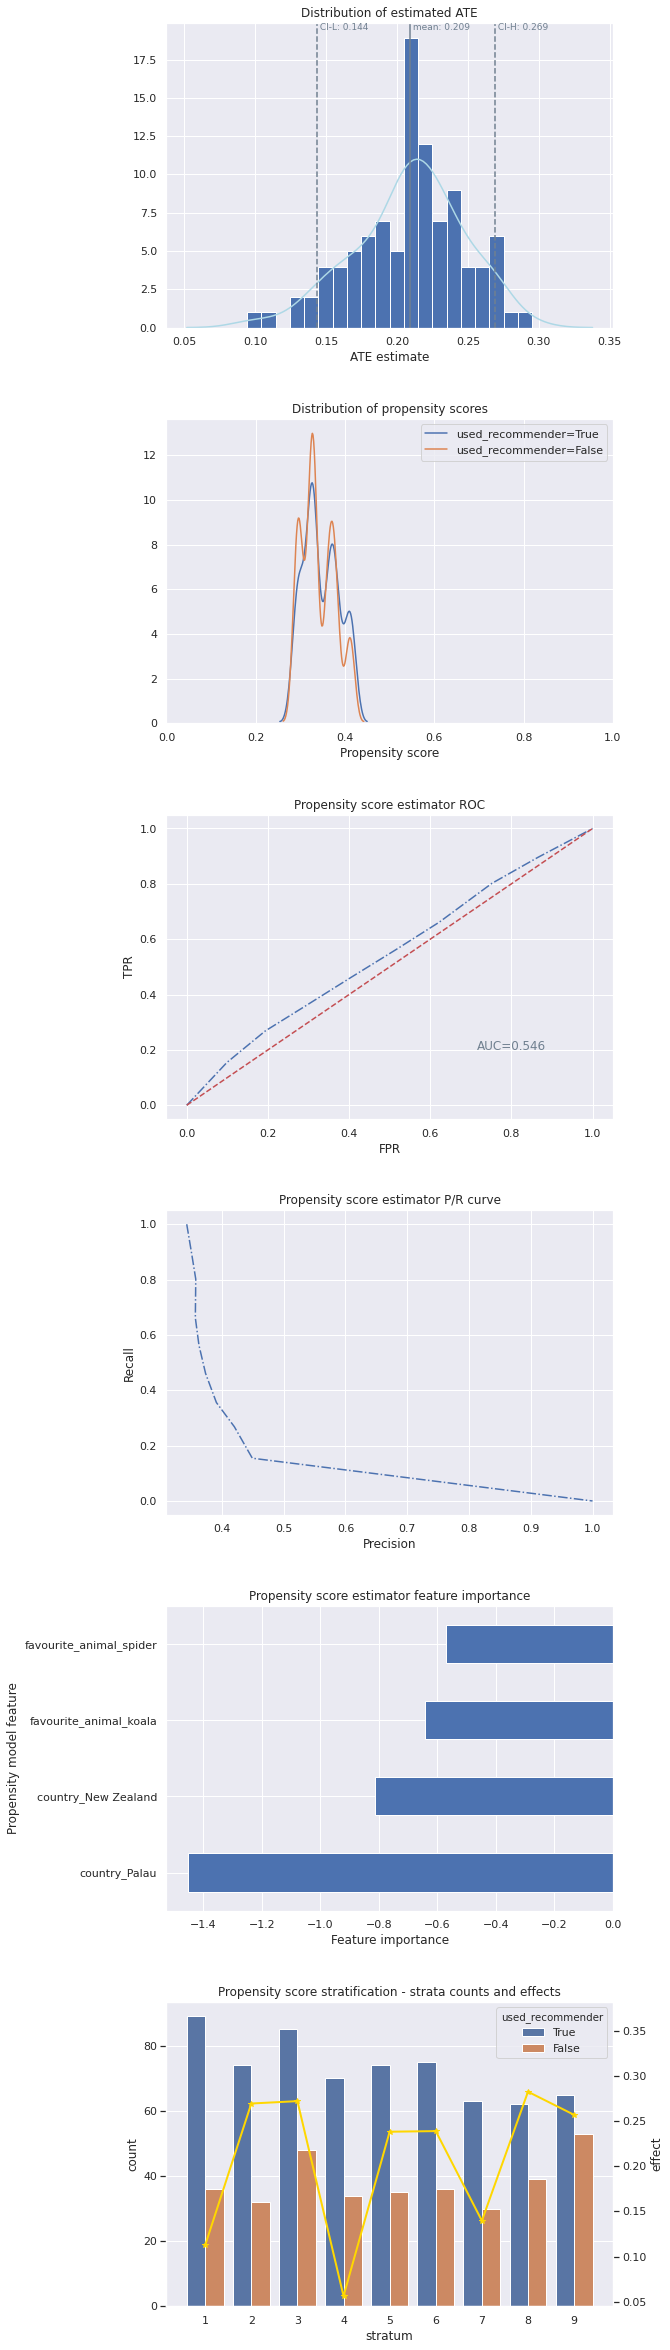

(array([<matplotlib.axes._subplots.AxesSubplot object at 0x7febac170760>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7febace44d00>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7febac0d7130>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7febac087790>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7febac1f2190>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7febac144100>],
 dtype=object),
 <Figure size 576x3024 with 7 Axes>)

In [ ]:
causal_estimate_plots(estimate, df_main_pd, treatment_name)

#### Refutation

Validation of causal model assumptions. If any of the refutation methods does not pass, consider reviewing the causal model.

**Warning:** this could run for a long time.

In [ ]:
def refutation(model, identified_estimand, estimate, methods=['random_common_cause', 'placebo_treatment_refuter', 'data_subset_refuter']):
    from copy import deepcopy
    estimate_ = deepcopy(estimate)
    estimate_.estimator._confidence_intervals = None
    
    results = []
    # random common cause
    if 'random_common_cause' in methods:
        print(f"{time.asctime()} - Running random common cause refuter.")
        try:
            refute_results_0 = model.refute_estimate(identified_estimand, 
                                                     estimate_, 
                                                     method_name="random_common_cause", 
                                                     confounders_effect_on_treatment="binary_flip", 
                                                     confounders_effect_on_outcome="binary_flip")
            print(refute_results_0.__str__() + 'Ideally we want `Estimated effect` to be close to `New effect` (stat. test not available).\n')
        except Exception as e:
            refute_results_0 = e
            print(e)
        results.append(refute_results_0)
    # placebo treatment refuter
    if 'placebo_treatment_refuter' in methods:
        print(f"{time.asctime()} - Running placebo treatment refuter.")
        try:
            refute_results_1 = model.refute_estimate(identified_estimand, estimate_, method_name="placebo_treatment_refuter", placebo_type="Random Data", num_simulations=10)
            sig_ = refute_results_1.refutation_result['p_value'] <= 0.05
            sig_summary_ = (
                f"'New effect' is significantly different from 0\n--> CHECK\n" if sig_
                else f"'New effect' is not significantly different from 0\n--> OK\n"
            )
            print(refute_results_1.__str__() + sig_summary_)
        except Exception as e:
            refute_results_1 = e
            print(e)
        results.append(refute_results_1)
    # data subset refuter
    if 'data_subset_refuter' in methods:
        print(f"{time.asctime()} - Running data subset refuter.")
        try:
            refute_results_2 = model.refute_estimate(identified_estimand, estimate_, method_name="data_subset_refuter", subset_fraction=0.1, num_simulations=10, random_state=seed)
            sig_ = refute_results_2.refutation_result['p_value'] <= 0.05
            sig_summary_ = (
                f"'New effect' is significantly different from `Estimated effect`\n--> CHECK\n" if sig_
                else f"'New effect' is not significantly different from `Estimated effect`\n--> OK\n"
            )
            print(refute_results_2.__str__() + sig_summary_)
        except Exception as e:
            refute_results_2 = e
            print(e)
        results.append(refute_results_2)
    return dict(zip(methods, results))


refute_results = refutation(model, identified_estimand, estimate)

refute_results

Mon Jun 7 11:03:06 2021 - Running random common cause refuter.
Refute: Add a Random Common Cause
Estimated effect:0.20899836438052846
New effect:0.2089982006057741
Ideally we want `Estimated effect` to be close to `New effect` (stat. test not available).

Mon Jun 7 11:03:11 2021 - Running placebo treatment refuter.
Refute: Use a Placebo Treatment
Estimated effect:0.20899836438052846
New effect:-0.0009437063888565019
p value:0.48860694995260645
'New effect' is not significantly different from 0
--> OK

Mon Jun 7 11:03:56 2021 - Running data subset refuter.
Method requires strata with number of data points per treatment > clipping_threshold (=10). No such strata exists. Consider decreasing 'num_strata' or 'clipping_threshold' parameters.
Out[14]: {'random_common_cause': <dowhy.causal_refuter.CausalRefutation at 0x7febb450a430>,
 'placebo_treatment_refuter': <dowhy.causal_refuter.CausalRefutation at 0x7febac180d60>,
 'data_subset_refuter': ValueError("Method requires strata with number of data points per treatment > clipping_threshold (=10). No such strata exists. Consider decreasing 'num_strata' or 'clipping_threshold' parameters.")}

In [ ]:
dbutils.notebook.exit(0)

0

***

Creating bogus data for testing

In [ ]:
fname = "s3://.../bogus-causality-dataset-00"

df_ = pd.DataFrame({
    "used_recommender":np.random.rand(1000) < .33,
    "team": np.random.choice(["greens", "blues"], 1000),
    "country": np.random.choice(("Andorra", "Palau", "New Zealand"), 1000),
    "favourite_animal": np.random.choice(("koala", "spider", "bee"), 1000)
})

spark.createDataFrame(df_).write.mode("overwrite").parquet(fname)

In [ ]:
fname = "s3://.../bogus-causality-dataset-01"

df_ = pd.DataFrame({
    "used_recommender":np.random.rand(1000) < .33,
    "team": np.random.choice(["greens", "blues"], 1000),
    "country": np.random.choice(("Andorra", "Palau", "New Zealand"), 1000),
    "favourite_animal": np.random.choice(("koala", "spider", "bee"), 1000)
})
df_["team"] = df_["used_recommender"].apply(lambda x: "blues" if np.random.rand() < 0.4 + x*0.2 else "greens", 1)

spark.createDataFrame(df_).write.mode("overwrite").parquet(fname)

model_ = """
digraph {
U;
used_recommender -> team_blues;
U -> used_recommender;
U -> team_blues;
country -> used_recommender;
country -> team_blues;
country -> favourite_animal;
}
"""

In [ ]:
fname = "s3://.../bogus-causality-dataset-02"

df_ = pd.DataFrame({
    "used_recommender":np.random.rand(1000) < .33,
    "team": np.random.choice(["greens", "blues"], 1000),
    "country": np.random.choice(("Andorra", "Palau", "New Zealand"), 1000),
    "favourite_animal": np.random.choice(("koala", "spider", "bee"), 1000)
})
df_["team"] = df_["used_recommender"].apply(lambda x: "blues" if np.random.rand() < 0.48 + x*0.04 else "greens", 1)

spark.createDataFrame(df_).write.mode("overwrite").parquet(fname)

model_ = """
digraph {
U;
used_recommender -> team_blues;
U -> used_recommender;
U -> team_blues;
country -> used_recommender;
country -> team_blues;
country -> favourite_animal;
}
"""

In [ ]:
fname = "s3://.../bogus-causality-dataset-03"

df_ = pd.DataFrame({
    "used_recommender":np.random.rand(1000) < .33,
    "team": np.random.choice(["greens", "blues"], 1000),
    "country": np.random.choice(("Andorra", "Palau", "New Zealand"), 1000),
    "favourite_animal": np.random.choice(("koala", "spider", "bee"), 1000)
})
df_["team"] = df_["used_recommender"].apply(lambda x: "blues" if np.random.rand() < 0.55 - x*0.1 else "greens", 1)

spark.createDataFrame(df_).write.mode("overwrite").parquet(fname)

model_ = """
digraph {
U;
used_recommender -> team_blues;
U -> used_recommender;
U -> team_blues;
country -> used_recommender;
country -> team_blues;
country -> favourite_animal;
}
"""